# Autoencoder Multivariate Training (Expiriment 3)

 Vinayak Sharma
  
 This notebook aims to train an autoencoder on univariate timeseries data from EKS Performance metrics for MANY NODES. The training data is 'non-anomalous'. 

 The model and implementation techniques can be found in the following github: https://github.com/emerelte/kad
 
 The research paper that this work is based on can be found here: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9925210

------

In [3]:
##global variable
timesteps = 12
time_steps = 12
batch_size = 6
n_samples = batch_size*100
features = ['node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

## Imports

In [4]:
# !pip install -r /root/eks-ml-pipeline/modeling/kad/kad/requirements.txt
# # # !pip install keras
# # # !pip install tensorflow

In [5]:
# !pip install tensorflow

In [6]:
# import matplotlib as mpl
# mpl.rcParams.keys()

In [14]:
# pip install tensorflow

In [15]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
import keras
from keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from autoencoder_model_dish_5g import Autoencoder_Model_Dish_5g

from sklearn.model_selection import train_test_split

import _pickle as cPickle


In [16]:
pd.set_option('display.max_rows', None)

First lets read in our training sample set 

In [17]:
training_df_full = pd.read_parquet('/root/healthy_clusters_node_month.parquet')

In [18]:
training_df_full.head()

,Timestamp,InstanceId,ClusterName,node_cpu_utilization,node_cpu_limit,node_cpu_request,node_cpu_usage_total,node_memory_utilization,node_memory_request,node_memory_limit,node_network_rx_bytes,node_network_rx_dropped,node_network_rx_errors,node_network_rx_packets,node_network_total_bytes,node_network_tx_bytes,node_network_tx_dropped,node_network_tx_errors,node_network_tx_packets
0,1654235914008,i-01470d8d8e7b4fd2f,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,2.905276,4000.0,1266.0,116.211031,9.394841,998244352,16476487680,26133.384568,0.0,0.0,87.334264,56498.252063,30364.867495,0.0,0.0,86.300537
1,1654235917104,i-0b36e8825c482f762,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,1.836838,4000.0,1066.0,73.473529,7.296163,851443712,16476487680,5812.096097,0.0,0.0,22.781011,13940.610609,8128.514512,0.0,0.0,22.814785
2,1654232669947,i-01470d8d8e7b4fd2f,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,2.950336,4000.0,1266.0,118.013421,9.399117,998244352,16476487680,24538.169434,0.0,0.0,86.939803,54629.097665,30090.928231,0.0,0.0,86.904324
3,1654232681444,i-0b36e8825c482f762,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,1.858162,4000.0,1066.0,74.326468,7.295069,851443712,16476487680,5451.981961,0.0,0.0,21.206624,13392.905270,7940.923309,0.0,0.0,21.632175
4,1654235970093,i-093473861e74eaf2d,mt-ndc-eks-cluster-dev-mt-use1,0.942944,16000.0,1266.0,150.871041,4.956222,998244352,65902239744,42229.503040,0.0,0.0,251.934982,90291.404482,48061.901442,0.0,0.0,251.558398


In [19]:
columns_to_keep = ['Timestamp','InstanceId','node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

In [20]:
training_df = training_df_full.drop(training_df_full.columns.difference(columns_to_keep),1, inplace=False)
training_df['Timestamp'] = pd.to_datetime(training_df['Timestamp'], unit='ms')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [21]:
len(training_df)

2636965

In [22]:
training_df = training_df.dropna()

In [23]:
test_df = training_df.copy()
training_df = training_df[training_df.InstanceId != 'i-0b36e8825c482f762']

-----

# TRAIN DATASET: Build out Dataset for training on many nodes

now we are starting to build out a training dataset for two nodes. This will prove our understanding of how to model can generalize across many EC2 instances. 

In [24]:
## for normalization
# scaler = StandardScaler()

scaler = MinMaxScaler(feature_range=(0, 1))

In [25]:

instance_dfs =[]
for instance in training_df['InstanceId'].unique():
    instance_dfs.append(training_df[training_df.InstanceId == instance].sort_values(by='Timestamp')\
                        .reset_index(drop=True))

import random 

x_train = np.zeros((n_samples,time_steps,len(features)))
for b in range(n_samples):
    
    ##pick random df, and normalize
    df = random.choice(instance_dfs)
    df = df.drop(columns = ['InstanceId'])
    df = df.set_index('Timestamp')
    df = df.sort_index()
    df[features] = scaler.fit_transform(df[features])
    
    
    
    sample = np.zeros((n_samples,len(features)))
    ##make sure length of df is atleast 40
    first_time = random.choice(range(len(df)-time_steps))
    df.head()
    sample = df[features].iloc[first_time:first_time+time_steps]
    x_train[b] = sample

x_train.shape

(600, 12, 3)

our xtrain shape has the following properties: (sample size, time steps, numFeatures)

-------

# TEST DATASET: Build out Dataset for testing on one node

In [28]:
test_df = test_df[test_df.InstanceId == 'i-0b36e8825c482f762']

In [29]:
test_df.head()

,Timestamp,InstanceId,node_cpu_utilization,node_memory_utilization,node_network_total_bytes
1,2022-06-03 05:58:37.104,i-0b36e8825c482f762,1.836838,7.296163,13940.610609
3,2022-06-03 05:04:41.444,i-0b36e8825c482f762,1.858162,7.295069,13392.905270
9,2022-06-03 05:59:35.385,i-0b36e8825c482f762,1.824157,7.296387,14073.509120
11,2022-06-03 05:05:34.448,i-0b36e8825c482f762,1.821361,7.297928,14987.560707
17,2022-06-03 06:00:39.866,i-0b36e8825c482f762,1.811754,7.299718,13253.130119


In [30]:
## drop the instanceId
test_df = test_df.drop("InstanceId",1, inplace=False)


##set timestamp as the index
test_df = test_df.set_index('Timestamp')

##normalize test_df 
test_df[features] = scaler.fit_transform(test_df[features])


##ensure the data is sorted!!
test_df = test_df.sort_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


----

# Model Time

----

### First we train

In [31]:
model = Autoencoder_Model_Dish_5g(batch_size = batch_size, time_steps = time_steps)

In [32]:
# model: i_model.IModel = autoencoder_model.AutoEncoderModel(batch_size = batch_size, time_steps = time_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 12, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 12, 3)            387       
 ibuted)                                                

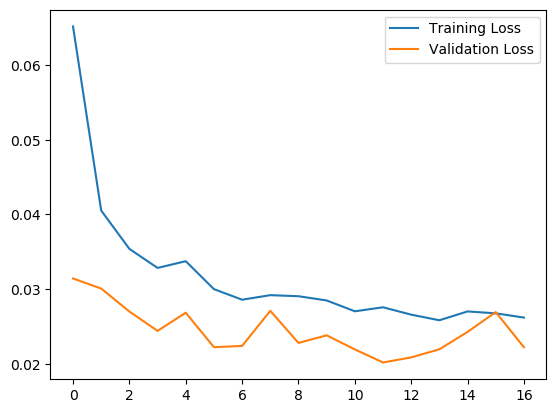

19/19 [==============================] - 1s 7ms/step
error_threshold 0.6736855972615876


In [33]:
val_err = model.train(x_train)


In [27]:
with open(r"eks_Trained_Autoencoder.pickle", "wb") as output_file:
    cPickle.dump(model, output_file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dropout
.........vars
......dropout_1
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
......repeat_vector
.........vars
......time_distributed
.........layer
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2022-11-21 23:35:21           64
config.json                        

### Then we test

In [28]:
with open(r"eks_Trained_Autoencoder.pickle", "rb") as input_file:
    model = cPickle.load(input_file)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2022-11-21 23:35:20           64
config.json                                    2022-11-21 23:35:20         3568
variables.h5                                   2022-11-21 23:35:20      2429752
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dropout
.........vars
......dropout_1
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
......repeat_vector
.........vars
......time_distributed
.........layer
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
......

In [29]:
# predictions = []
# anomaly_scores = []

# for i in range(0,len(test_df),12*5):
#     if(i + 12*5 < len(test_df)):
#         sample_topredict_on = test_df.iloc[i:i+12*5]
# #         display(sample_topredict_on)
#         x_test = np.array(sample_topredict_on['node_cpu_utilization'].tolist())
#         x_test = x_test.reshape(1,-1,1)
#         preds,anom_scores = model.testnew(x_test)
#         predictions.append(preds)
#         anomaly_scores.append(anom_scores)




predictions_f1 = []
predictions_f2 = []
predictions_f3 = []

errors_f1 = []
errors_f2 = []
errors_f3 = []

anomaly_scoresf1 = []
anomaly_scoresf2 = []
anomaly_scoresf3 = []




for i in range(0,len(test_df),timesteps):
    if(i + timesteps < len(test_df)):
        sample_topredict_on = test_df.iloc[i:i+timesteps]
        x_test = np.array(sample_topredict_on.to_numpy())
        x_test = x_test.reshape(1,-1,3)
        preds,errs,anom_scores = model.test(x_test)
        
        predictions_f1.append(np.array(preds[:,:,0]))
        predictions_f2.append(preds[:,:,1])
        predictions_f3.append(preds[:,:,2])
        
        anomaly_scoresf1.append(np.array(anom_scores[:timesteps,:]))
        anomaly_scoresf2.append(anom_scores[timesteps:timesteps+timesteps,:])
        anomaly_scoresf3.append(anom_scores[timesteps+timesteps:timesteps+timesteps+timesteps,:])
        
        
        errors_f1.append(np.array(errs[:,:,0]))
        errors_f2.append(errs[:,:,1])
        errors_f3.append(errs[:,:,2])
        


1/1 [==============================] - 0s 18ms/step


KeyboardInterrupt: 

### Visualize Testing

In [ ]:
predictions_f1 = np.concatenate(np.concatenate(predictions_f1,axis=0),axis=0)
predictions_f2 = np.concatenate(np.concatenate(predictions_f2,axis=0),axis=0)
predictions_f3 = np.concatenate(np.concatenate(predictions_f3,axis=0),axis=0)

anomaly_scoresf1 = np.concatenate(np.concatenate(anomaly_scoresf1,axis=0),axis=0)
anomaly_scoresf2 = np.concatenate(np.concatenate(anomaly_scoresf2,axis=0),axis=0)
anomaly_scoresf3 = np.concatenate(np.concatenate(anomaly_scoresf3,axis=0),axis=0)

errors_f1 = np.concatenate(np.concatenate(errors_f1,axis=0),axis=0)
errors_f2 = np.concatenate(np.concatenate(errors_f2,axis=0),axis=0)
errors_f3 = np.concatenate(np.concatenate(errors_f3,axis=0),axis=0)


In [ ]:
df_results_f1  = test_df[['node_cpu_utilization']].copy().iloc[0:len(anomaly_scoresf1)]
df_results_f2  = test_df[['node_memory_utilization']].copy().iloc[0:len(anomaly_scoresf1)]
df_results_f3  = test_df[['node_network_total_bytes']].copy().iloc[0:len(anomaly_scoresf1)]

In [ ]:
df_results_f1['predictions'] = predictions_f1
df_results_f1['error'] = errors_f1
df_results_f1['anom_score'] = anomaly_scoresf1



df_results_f2['predictions'] = predictions_f2
df_results_f2['error'] = errors_f2
df_results_f2['anom_score'] = anomaly_scoresf2



df_results_f3['predictions'] = predictions_f3
df_results_f3['error'] = errors_f3
df_results_f3['anom_score'] = anomaly_scoresf3

In [ ]:
def anom_threshold_function(x):
    if(x > 0.8): return True
    else: return False

In [ ]:
df_results_f1['is_anomaly'] = df_results_f1['anom_score'].apply(anom_threshold_function)
df_results_f2['is_anomaly'] = df_results_f2['anom_score'].apply(anom_threshold_function)
df_results_f3['is_anomaly'] = df_results_f3['anom_score'].apply(anom_threshold_function)






In [ ]:
# evaluation_df[kad_utils.GROUND_TRUTH_COLUMN] = training_df_one_node[kad_utils.GROUND_TRUTH_COLUMN]
model.visualize(df_results_f1, "node_cpu_utilization")
plt.show()

In [ ]:
model.visualize(df_results_f2, "node_memory_utilization")
plt.show()

In [ ]:
model.visualize(df_results_f3, "node_network_total_bytes")
plt.show()